In [10]:
% matplotlib inline
########## DISABLE GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys

sys.path.append("../vsegmenter")

import matplotlib.pyplot as plt
import numpy as np
import unet
from unet import utils
from unet.datasets import circles
import numpy as np
import tensorflow as tf

from vsegmenter import cfg
from vsegmenter.data import dataset
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from unet import custom_objects


In [1]:
model_file = cfg.results("segmenter_v2.model")
unet_model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

NameError: name 'cfg' is not defined

In [3]:
from model.train import get_datasets

# train_dataset, validation_dataset = circles.load_data(100, nx=200, ny=200, splits=(0.7, 0.3))
train_dataset, validation_dataset = get_datasets("v3")

Number of train samples: 400, test samples = 100
Sample dimensions: sample: (128, 128, 3) label (mask): (128, 128, 2)
Original image shape : (400, 128, 128, 3)


In [29]:
num_images = 20
# extraer un array de imágenes del conjunto de validación
validation_images = []
validation_labels = []
for image, label in validation_dataset.shuffle(100).take(num_images):
    validation_images.append(image.numpy())
    validation_labels.append(label.numpy())
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# hacer las predicciones para las imágenes seleccionadas
prediction = unet_model.predict(validation_images)

In [30]:
# create mask from model preditions
pred_mask = tf.math.argmax(prediction, axis=-1)


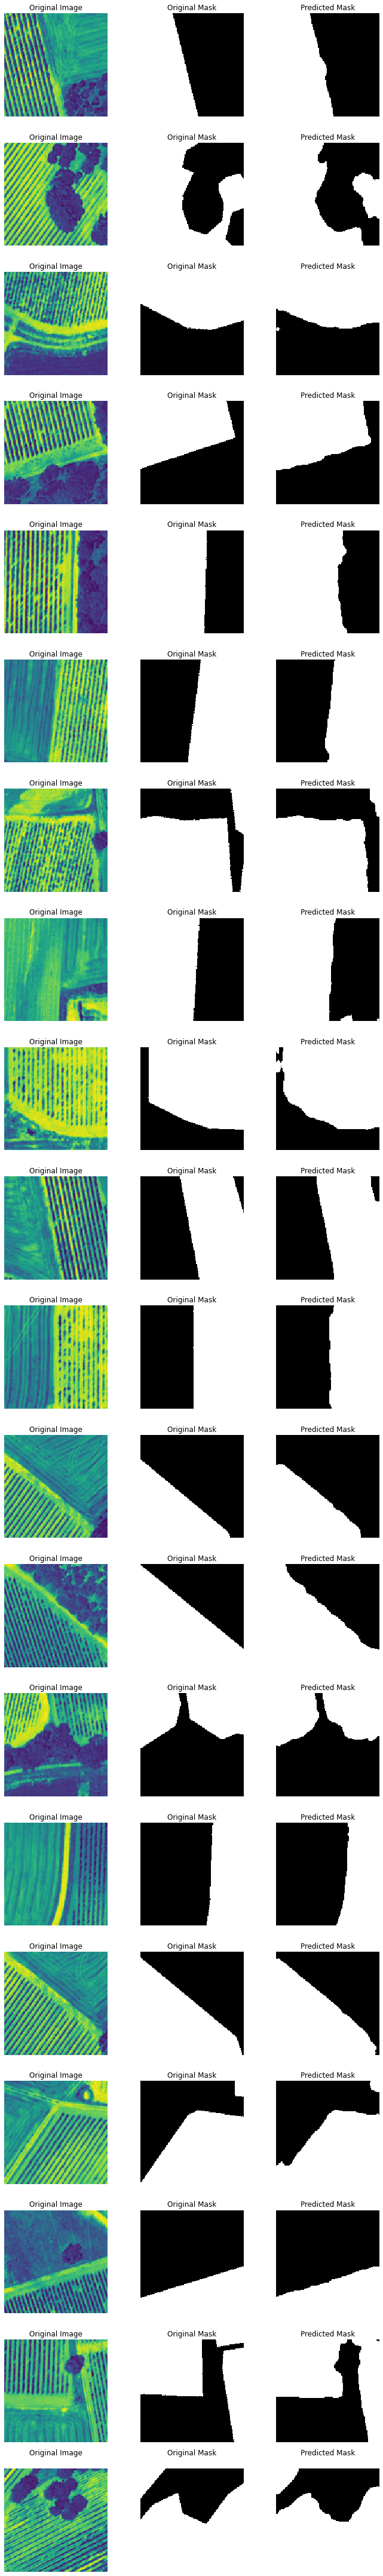

In [31]:
# crear la figura para mostrar las imágenes
fig, ax = plt.subplots(num_images, 3, sharex=True, sharey=True, figsize=(10, int(num_images * 3)))

# iterar sobre las imágenes seleccionadas y mostrar las imágenes y las máscaras originales y predichas
for i in range(num_images):
    ax[i][0].matshow(validation_images[i][..., -1]);
    ax[i][0].set_title('Original Image');
    ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(validation_labels[i], axis=-1), cmap=plt.cm.gray);
    ax[i][1].set_title('Original Mask');
    ax[i][1].axis('off')
    ax[i][2].matshow(pred_mask[i, ...], cmap=plt.cm.gray);
    ax[i][2].set_title('Predicted Mask');
    ax[i][2].axis('off')
    # ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')

# ajustar el diseño de las imágenes en la figura
plt.tight_layout()
